# Get probabilistic mass measurements for Kepler-431 using Forecaster.

In [8]:
import numpy as np
import forecaster.mr_forecast as mr
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
import pandas as pd
import time
import pickle 
from collections import OrderedDict
from generatefeatures import generate_features
%matplotlib inline

Get mass samples for Kepler-431 using data from NASAEA and Morton et al. (2016) - http://adsabs.harvard.edu/abs/2016ApJ...822...86M

In [33]:
#mean/std radius measurements, earth radii
mu1, std1 = 0.77, 0.15    
mu2, std2 = 0.76, 0.15
mu3, std3 = 1.08, 0.205

n_samples = 250

#generate samples from normal distribution
r1 = np.random.normal(mu1,std1,n_samples)
r2 = np.random.normal(mu2,std2,n_samples)
r3 = np.random.normal(mu3,std3,n_samples)

#radius samples -> probabilistic mass samples
m1 = mr.Rpost2M(r1, unit='Earth', grid_size=1e3, classify='Yes')  #earth masses
m2 = mr.Rpost2M(r2, unit='Earth', grid_size=1e3, classify='Yes')
m3 = mr.Rpost2M(r3, unit='Earth', grid_size=1e3, classify='Yes')

Terran 92.0 %, Neptunian 8.0 %, Jovian 0.0 %, Star 0.0 %
Terran 93.6 %, Neptunian 6.4 %, Jovian 0.0 %, Star 0.0 %
Terran 72.4 %, Neptunian 27.6 %, Jovian 0.0 %, Star 0.0 %


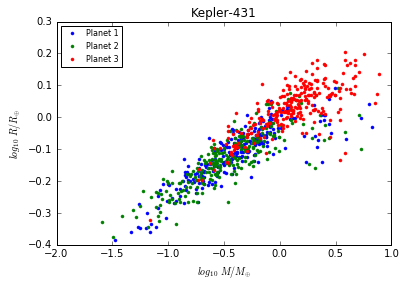

In [34]:
plt.plot(np.log10(m1), np.log10(r1), '.', label='Planet 1')
plt.plot(np.log10(m2), np.log10(r2), '.', label='Planet 2')
plt.plot(np.log10(m3), np.log10(r3), '.', label='Planet 3')
plt.xlabel(r'$log_{10}\ M/M_{\oplus}$')
plt.ylabel(r'$log_{10}\ R/R_{\oplus}$')
plt.legend(loc='upper left', numpoints=1, fontsize=8)
plt.title('Kepler-431')

## Generate Dataframe for Kepler-431

In [35]:
from random import random, uniform, seed
def draw_e(P1,P2,P3,m1,m2,m3,Ms):
    a1, a2, a3 = ((P1/365)**2 * Ms)**(1./3.), ((P2/365)**2 * Ms)**(1./3.), ((P3/365)**2 * Ms)**(1./3.)

    ecrit1 = (a2-a1)/a1
    ecrit21 = (a2-a1)/a2
    ecrit23 = (a3-a2)/a2
    ecrit3 = (a3-a2)/a3

    logemax1 = np.log10(ecrit1)
    logemax2 = np.log10(min(ecrit21, ecrit23))
    logemax3 = np.log10(ecrit3)

    earth = 0.000003003
    logemin1 = np.log10(m2*earth/ecrit1**2)
    logemin2 = np.log10(max(m1*earth/ecrit21**2, m3*earth/ecrit23**2))
    logemin3 = np.log10(m2*earth/ecrit3**2)
    
    e1 = min(10.**uniform(logemin1, logemax1), 1.) # make sure ecc < 1
    e2 = min(10.**uniform(logemin2, logemax2), 1.)
    e3 = min(10.**uniform(logemin3, logemax3), 1.)
    return e1, e2, e3

In [36]:
Ms = 1.071                            #Solar mass units
P1, P2, P3 = 6.803, 8.703, 11.922     #days
w1, w2, w3 = 2*np.pi*np.random.random(n_samples),2*np.pi*np.random.random(n_samples),2*np.pi*np.random.random(n_samples)
MA1, MA2, MA3 = 2*np.pi*np.random.random(n_samples),2*np.pi*np.random.random(n_samples),2*np.pi*np.random.random(n_samples)
e = []
for i in range(n_samples):
    e.append(draw_e(P1,P2,P3,m1[i],m2[i],m3[i],Ms))
e1, e2, e3 = zip(*np.asarray(e))

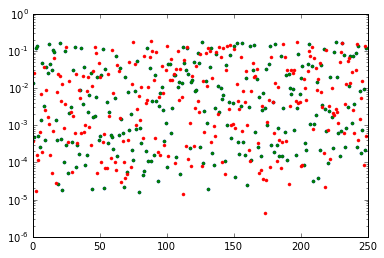

In [37]:
plt.plot(e1, '.')
plt.plot(e1, '.')
plt.plot(e3, '.')
plt.yscale('log')

In [38]:
data = []
for i in range(n_samples):
    data.append([m1[i],MA1[i],P1,e1[i],w1[i],m2[i],MA2[i],P2,e2[i],w2[i],m3[i],MA3[i],P3,e3[i],w3[i]])
data = pd.DataFrame(np.asarray(data),columns=["m1","MA1","P1","e1","w1","m2","MA2","P2","e2","w2","m3","MA3","P3","e3","w3"])

In [39]:
data.head()

,m1,MA1,P1,e1,w1,m2,MA2,P2,e2,w2,m3,MA3,P3,e3,w3
0,0.190323,1.922614,6.803,0.013274,2.076118,0.548149,5.444703,8.703,0.003679,5.690501,0.504507,5.983768,11.922,0.000372,4.412395
1,0.362025,0.952130,6.803,0.000496,1.162948,0.276461,4.141902,8.703,0.001693,4.375519,1.000302,1.206019,11.922,0.025620,6.009131
2,1.109612,2.163423,6.803,0.119979,3.065306,0.078009,3.863810,8.703,0.070324,2.642439,0.595567,5.599364,11.922,0.000017,0.285293
3,0.139435,3.290191,6.803,0.134269,6.111329,0.620793,2.178322,8.703,0.012962,6.070029,1.942618,0.395234,11.922,0.000155,2.807998
4,0.239099,4.372711,6.803,0.000517,0.758024,0.796238,0.305502,8.703,0.034731,4.983430,2.024899,0.896373,11.922,0.000118,1.670759


In [40]:
def predict_system(system,data,Ms,n_sims,model,save_data,epoch=0):
    
    # run models
    start = time.time()
    fullfeatures = []
    for index, d in data.iterrows():
        fullfeatures.append(generate_features(d, Ms, epoch))
    print "%d simulations took %f seconds"%(n_sims, time.time() - start)
    
    model = pickle.load(open('OptimalXGBmodel.pkl', 'rb'))
    
    features = []
    features += ['avg_iH1', 'avg_iH2']
    features += ['norm_std_a1', 'norm_max_a1', 'norm_std_window10_a1', 'norm_max_window10_a1']
    features += ['norm_std_a2', 'norm_max_a2', 'norm_std_window10_a2', 'norm_max_window10_a2']
    features += ['norm_std_a3', 'norm_max_a3', 'norm_std_window10_a3', 'norm_max_window10_a3']
    features += ['avg_ecross1', 'std_ecross1', 'max_ecross1', 'min_ecross1']
    features += ['avg_ecross2', 'std_ecross2', 'max_ecross2', 'min_ecross2']
    features += ['avg_ecross3', 'std_ecross3', 'max_ecross3', 'min_ecross3']
    features += ['norm_a1_slope', 'norm_a2_slope', 'norm_a3_slope']
    features += ['Lyapunov_time']
    
    # compile results - take only the features the model uses
    results = pd.DataFrame(columns=features)
    for i in range(len(fullfeatures)):
        results.loc[i] = fullfeatures[i][features] 
        
    # predict stability 
    results["predict_proba"] = model.predict_proba(results)[:,1]
    
    data.to_csv("systems/%s_data.csv"%system)
    results.to_csv("systems/%s_results.csv"%system)
    return data, results

Run system, will take a second

In [41]:
model = "OptimalXGBmodel.pkl"   #pre-trained machine learning model
save_data = 1

#run
data, results = predict_system("Kepler-431",data,Ms,n_samples,model,save_data)

250 simulations took 165.794551 seconds


In [42]:
data.head()

,m1,MA1,P1,e1,w1,m2,MA2,P2,e2,w2,m3,MA3,P3,e3,w3
0,0.190323,1.922614,6.803,0.013274,2.076118,0.548149,5.444703,8.703,0.003679,5.690501,0.504507,5.983768,11.922,0.000372,4.412395
1,0.362025,0.952130,6.803,0.000496,1.162948,0.276461,4.141902,8.703,0.001693,4.375519,1.000302,1.206019,11.922,0.025620,6.009131
2,1.109612,2.163423,6.803,0.119979,3.065306,0.078009,3.863810,8.703,0.070324,2.642439,0.595567,5.599364,11.922,0.000017,0.285293
3,0.139435,3.290191,6.803,0.134269,6.111329,0.620793,2.178322,8.703,0.012962,6.070029,1.942618,0.395234,11.922,0.000155,2.807998
4,0.239099,4.372711,6.803,0.000517,0.758024,0.796238,0.305502,8.703,0.034731,4.983430,2.024899,0.896373,11.922,0.000118,1.670759


Analyze a particular system

In [43]:
results.head()

,avg_iH1,avg_iH2,norm_std_a1,norm_max_a1,norm_std_window10_a1,norm_max_window10_a1,norm_std_a2,norm_max_a2,norm_std_window10_a2,norm_max_window10_a2,...,min_ecross2,avg_ecross3,std_ecross3,max_ecross3,min_ecross3,norm_a1_slope,norm_a2_slope,norm_a3_slope,Lyapunov_time,predict_proba
0,0.0,0.0,0.000013,0.000040,0.000017,0.000039,0.000009,0.000031,0.000008,0.000019,...,0.024294,0.0,0.0,0.005340,0.001523,-2.298472e-12,-4.439341e-13,1.087982e-12,3925.130174,0.999815
1,0.0,0.0,0.000007,0.000031,0.000009,0.000014,0.000023,0.000078,0.000018,0.000034,...,0.011180,0.0,0.0,0.135368,0.131135,-3.182066e-12,6.102025e-12,-6.546894e-13,914.924491,0.989675
2,0.0,0.0,0.000014,0.000029,0.000014,0.000027,0.000063,0.000177,0.000060,0.000089,...,0.464402,0.0,0.0,0.101708,0.000088,-1.207594e-13,5.399066e-12,-1.694417e-12,930.411663,0.017471
3,0.0,0.0,0.000304,0.000669,0.000220,0.000350,0.000084,0.000178,0.000061,0.000132,...,0.084006,0.0,0.0,0.035023,0.000521,-5.260433e-10,1.430345e-10,-1.134995e-12,136.722612,0.153932
4,0.0,0.0,0.000032,0.000112,0.000028,0.000051,0.000034,0.000117,0.000049,0.000115,...,0.179749,0.0,0.0,0.051646,0.000485,-4.415211e-12,8.135975e-12,-4.067736e-12,1574.518221,0.442657


In [44]:
def collision(reb_sim, col):
    reb_sim.contents._status = 5 # causes simulation to stop running and have flag for whether sim stopped due to collision
    return 0

def get_rhill(d,Ms):
    earth = 0.000003003
    a1,a2 = ((d["P1"]/365)**2 * Ms)**(1./3.), ((d["P2"]/365)**2 * Ms)**(1./3.)
    hill12 = a1*((d["m1"]+d["m2"])*earth/Ms/3.)**(1./3.)
    hill23 = a2*((d["m2"]+d["m3"])*earth/Ms/3.)**(1./3.)
    return max(hill12,hill23)

In [45]:
import rebound
sim = rebound.Simulation()
sim.getWidget(scale=0.1)

In [46]:
sys = 3

d = data.iloc[sys]
sim.integrator = 'whfast'
sim.G = 1
sim.collision_resolve = collision
sim.add(m=Ms) # add a star

In [47]:
maxhill = get_rhill(d,Ms)
earth = 0.000003003
for i in range(1,4):
    sim.add(m=d["m%d"%i]*earth*Ms,P=d["P%d"%i]*2*np.pi/365.,e=d["e%d"%i],omega=d["w%d"%i],M=d["MA%d"%i],r=maxhill) 
sim.move_to_com() # Move to the centre of mass frame

P0 = sim.particles[1].P
sim.dt = P0/20.

In [48]:
sim.integrate(1e5*P0)